In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, add
from tensorflow.keras.preprocessing import image as tfkpreimage
from tensorflow.keras.applications import VGG16
from matplotlib import image as mimg
from matplotlib import pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip Pose_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Pose_Dataset/test/test103.jpg  
  inflating: Pose_Dataset/test/test104.jpg  
  inflating: Pose_Dataset/test/test105.jpg  
  inflating: Pose_Dataset/test/test106.jpg  
  inflating: Pose_Dataset/test/test107.jpg  
  inflating: Pose_Dataset/test/test108.jpg  
  inflating: Pose_Dataset/test/test109.jpg  
  inflating: Pose_Dataset/test/test11.jpg  
  inflating: Pose_Dataset/test/test110.jpg  
  inflating: Pose_Dataset/test/test111.jpg  
  inflating: Pose_Dataset/test/test112.jpg  
  inflating: Pose_Dataset/test/test113.jpg  
  inflating: Pose_Dataset/test/test114.jpg  
  inflating: Pose_Dataset/test/test115.jpg  
  inflating: Pose_Dataset/test/test116.jpg  
  inflating: Pose_Dataset/test/test117.jpg  
  inflating: Pose_Dataset/test/test118.jpg  
  inflating: Pose_Dataset/test/test119.jpg  
  inflating: Pose_Dataset/test/test12.jpg  
  inflating: Pose_Dataset/test/test120.jpg  
  inflating: Pose_Dataset/test/test121.jpg  
  infl

In [ ]:
train_joints_coords_targets = pd.read_csv("Pose_Dataset/train_joints_coords.csv",header=None)
test_joints_coords_targets = pd.read_csv("Pose_Dataset/test_joints_coords.csv",header=None)

In [ ]:
train_joints_coords_targets.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,train0.jpg,190,160,149,137,151,84,122,34,47,77,31,141,31,190
1,train1.jpg,192,137,148,122,138,77,109,40,47,79,36,140,34,184
2,train2.jpg,190,139,147,116,139,72,103,33,37,82,33,148,47,188
3,train3.jpg,185,157,145,134,141,82,114,41,38,85,32,149,76,184
4,train4.jpg,44,182,38,139,53,83,119,38,155,91,172,139,195,177


In [ ]:
test_joints_coords_targets.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,test0.jpg,182,175,156,151,153,82,132,33,59,68,45,136,37,189
1,test1.jpg,183,184,185,140,151,82,118,44,58,90,41,159,105,155
2,test2.jpg,183,185,182,124,146,73,115,36,42,81,48,146,121,101
3,test3.jpg,185,186,190,121,156,66,123,33,56,75,41,149,111,136
4,test4.jpg,144,144,183,144,157,80,94,34,35,75,35,147,57,188


In [ ]:
image_data_train = []
image_data_test = []

In [ ]:
traindir = "Pose_Dataset/train"
for i in os.listdir(traindir):
  im = plt.imread(os.path.join(traindir,i))
  im = cv2.resize(im,(224,224))
  image_data = tfkpreimage.img_to_array(im)
  # image_data /= 255.0
  image_data_train.append(image_data)

testdir = "Pose_Dataset/test"
for i in os.listdir(testdir):
  im1 = plt.imread(os.path.join(testdir,i))
  im1 = cv2.resize(im1,(224,224))
  image_data1 = tfkpreimage.img_to_array(im1)
  # image_data1 /= 255.0
  image_data_test.append(image_data1)

In [ ]:
print("Train",len(image_data_train))
print("Test",len(image_data_test))

Train 4429
Test 574


In [ ]:
train_joints_coords_targets["imageData"] = image_data_train

In [ ]:
train_joints_coords_targets.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,imageData
0,train0.jpg,190,160,149,137,151,84,122,34,47,77,31,141,31,190,"[[[69.0, 70.0, 91.0], [70.0, 71.0, 92.0], [72...."
1,train1.jpg,192,137,148,122,138,77,109,40,47,79,36,140,34,184,"[[[148.0, 161.0, 144.0], [152.0, 165.0, 147.0]..."
2,train2.jpg,190,139,147,116,139,72,103,33,37,82,33,148,47,188,"[[[156.0, 125.0, 133.0], [147.0, 122.0, 128.0]..."
3,train3.jpg,185,157,145,134,141,82,114,41,38,85,32,149,76,184,"[[[108.0, 107.0, 113.0], [100.0, 101.0, 106.0]..."
4,train4.jpg,44,182,38,139,53,83,119,38,155,91,172,139,195,177,"[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,..."


In [ ]:
test_joints_coords_targets["imageData"] = image_data_test

In [ ]:
test_joints_coords_targets.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,imageData
0,test0.jpg,182,175,156,151,153,82,132,33,59,68,45,136,37,189,"[[[2.0, 0.0, 3.0], [1.0, 0.0, 2.0], [1.0, 0.0,..."
1,test1.jpg,183,184,185,140,151,82,118,44,58,90,41,159,105,155,"[[[52.0, 74.0, 71.0], [55.0, 77.0, 74.0], [58...."
2,test2.jpg,183,185,182,124,146,73,115,36,42,81,48,146,121,101,"[[[9.0, 51.0, 127.0], [9.0, 51.0, 127.0], [9.0..."
3,test3.jpg,185,186,190,121,156,66,123,33,56,75,41,149,111,136,"[[[85.0, 118.0, 123.0], [84.0, 119.0, 125.0], ..."
4,test4.jpg,144,144,183,144,157,80,94,34,35,75,35,147,57,188,"[[[161.0, 181.0, 206.0], [158.0, 178.0, 202.0]..."


In [ ]:
from sklearn.model_selection import train_test_split
trainX, testx, trainY, testy = train_test_split(train_joints_coords_targets["imageData"],train_joints_coords_targets.iloc[:,1:15].astype('float32'), test_size=0.1, random_state=42, shuffle=True)

In [ ]:
trainX = np.array(trainX.to_list())
testx = np.array(testx.to_list())
testy = np.array(testy.values)
trainY = np.array(trainY.values)

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testx.shape)
print(testy.shape)

(3986, 224, 224, 3)
(3986, 14)
(443, 224, 224, 3)
(443, 14)


In [ ]:
print(trainY.dtype)
print(trainX.dtype)
print(testy.dtype)
print(testx.dtype)

print(type(trainY))
print(type(trainX))
print(type(testy))
print(type(testx))

float32
float32
float32
float32
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[190. 173. 181. 124. 161.  80.  98.  37.  37.  83.  37. 138.  66. 182.]


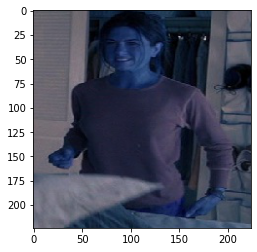

In [ ]:
plt.imshow(trainX[0].astype('uint8'))
print(trainY[0])

In [ ]:
batchsize = 32
targetsize = (224,224)
inputsize = (224,224,3)

In [ ]:
imagedatagenerator = ImageDataGenerator(validation_split=0.1)
train = imagedatagenerator.flow_from_dataframe(dataframe=train_joints_coords_targets,directory="Pose_Dataset/train/",x_col=0,y_col=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],subset='training',class_mode='raw',batch_size=batchsize,target_size=targetsize)
val = imagedatagenerator.flow_from_dataframe(dataframe=train_joints_coords_targets,directory="Pose_Dataset/train",x_col=0,y_col=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],subset='validation',class_mode='raw',batch_size=batchsize,target_size=targetsize)
test = imagedatagenerator.flow_from_dataframe(directory="/content/Pose_Dataset/test/",dataframe=test_joints_coords_targets,x_col=0,target_size=targetsize,batch_size=batchsize,class_mode=None)

Found 3987 validated image filenames.
Found 442 validated image filenames.
Found 574 validated image filenames.


**VGG16**

In [ ]:
conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

for layer in conv_base.layers:
    layer.trainable= False   #Here I am making the layers of the pretrained model as Non-Trainable

#Creating the model to be concatenated to the VGG16 model
def top_model():

    top_model = Sequential()  
    top_model.add(Conv2D(64,(3,3), activation='relu', padding = 'same', input_shape=conv_base.output_shape[1:])) 
    top_model.add(BatchNormalization())
    top_model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
    top_model.add(Flatten()) 
    top_model.add(Dense(4096, activation='relu')) 
    top_model.add(BatchNormalization()) 
    top_model.add(Dropout(0.5))
    top_model.add(Dense(14//ns, activation='relu')) 

    model = Sequential()
    # print("-------LAYER INFO-------")
    for layer in conv_base.layers:
        #if ("input" in layer.name):
        model.add(layer)     #Iterating through all the layers of VGG16 and adding them to a new model
    model.add(top_model)     #Concatenating the Top model to the new mode
    # print("-------LAYER INFO-------")
    # print("-------MODEL SUMMARY-------")
    # print(model.summary())
    # print("-------MODEL SUMMARY-------")
    return model

def create_model(n):
    outputs=[]
    for i in range(1,n+1):
        # print(i)
        globals()[f'model_{i}'] = top_model()
        
        outputs.append(globals()[f'model_{i}'].output)
    merged= add(outputs)
    output= Dense(14, activation='relu', kernel_initializer= 'Ones')(merged) 
    # print(outputs)
    final_model = Model(conv_base.input,output)
    
    return final_model
##BELOW CODE IS FOR JUST FOR KNOWLEDGE
# model = Sequential()
# for layer in conv_base.layers:
#   model.add(layer)
# model.summary()

In [ ]:
conv_base.summary() ##include_top=False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
conv_base.summary() ##include_top=True

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
conv_base.output

[<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>]

In [ ]:
ns=2 #Number of groups in which the model need to be build 
model3 = create_model(ns)   # ns: as Number of Stages  for training.
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[13][0]              
                                                                 block1_conv1[14][0]              
____________________________________________________________________________________________

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
metrics = [coeff_determination]
model3.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True),loss='mean_squared_error',metrics=metrics)

In [ ]:
early_stopping_monitor= EarlyStopping(monitor='coeff_determination', min_delta=0, patience=10, 
                                      verbose=1, mode= 'max', baseline=None, restore_best_weights=True)
reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.00001,verbose=1)

In [ ]:
model3traininghistory = model3.fit(trainX,trainY,validation_split=0.2,batch_size=batchsize,epochs=55,callbacks=[early_stopping_monitor,reducelronplateau],shuffle=True)

Epoch 1/55
100/100 [==============================] - 17s 160ms/step - loss: 3334.0510 - coeff_determination: -0.1161 - val_loss: 3043.0808 - val_coeff_determination: -0.0168
Epoch 2/55
100/100 [==============================] - 16s 156ms/step - loss: 1914.8856 - coeff_determination: 0.3586 - val_loss: 1707.0476 - val_coeff_determination: 0.4294
Epoch 3/55
100/100 [==============================] - 16s 156ms/step - loss: 1405.6786 - coeff_determination: 0.5293 - val_loss: 1196.0643 - val_coeff_determination: 0.6001
Epoch 4/55
100/100 [==============================] - 16s 156ms/step - loss: 1069.1436 - coeff_determination: 0.6422 - val_loss: 923.1100 - val_coeff_determination: 0.6913
Epoch 5/55
100/100 [==============================] - 16s 156ms/step - loss: 880.8360 - coeff_determination: 0.7050 - val_loss: 775.9455 - val_coeff_determination: 0.7404
Epoch 6/55
100/100 [==============================] - 16s 156ms/step - loss: 769.9366 - coeff_determination: 0.7419 - val_loss: 690.1789

In [ ]:
model3_json = model3.to_json()

In [ ]:
with open("pose_estimation.json",'w') as f:
  f.write(model3_json)

In [ ]:
model3.save_weights("pose_estimation.h5")

In [ ]:
model3.save("pose_etimation_full.h5")

In [ ]:
def plot_limb(img, joints, i, j, color):
    """Function to plot the limbs"""
    cv2.line(img, joints[i], joints[j], (255, 255, 255), thickness=2, lineType=16)
    cv2.line(img, joints[i], joints[j], color, thickness=1, lineType=16)
    return img

def plot_joints(img, joints, original=True, text_scale=0.5):
    """Function to draw the joints"""
    h, w, c = img.shape
    # Connecting the joints 
    if original:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 155, 70))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 155, 70))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 155, 70))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 155, 70))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 155, 70))
        
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 155, 70))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv2.circle(img, joint, 5, (50, 155, 70), -1)
            # plot joint number black
            cv2.putText(img, '%d' % j, joint, cv2.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=2, lineType=16)
            # plot joint number white
            cv2.putText(img, '%d' % j, joint, cv2.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    else:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 70, 155))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 70, 155))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 70, 155))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 70, 155))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 70, 155))
       
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 70, 155))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv2.circle(img, joint, 5, (50, 70, 155), -1)
            # plot joint number black
            cv2.putText(img, '%d' % j, joint, cv2.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=3, lineType=16)
            # plot joint number white
            cv2.putText(img, '%d' % j, joint, cv2.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    return img

In [ ]:
test_img_ids = test_joints_coords_targets.loc[:,0]

In [ ]:
testy = np.array(testy)

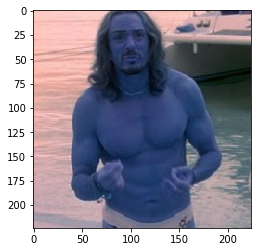

In [ ]:
plt.imshow(testx[1].astype('uint8'))

In [ ]:
predictions = model3.predict(testx, verbose = 0, batch_size=32)

# folder to save the results
if not os.path.exists(os.path.join(os.getcwd(), '/content/test_plot')):
    os.mkdir('/content/test_plot')

for i, (ids, im, joint, pred) in enumerate(zip(test_img_ids, testx, testy.astype('int'), predictions)):
    #print(joint)
    joints = joint.tolist()
    joints = list(zip(joints[0::2], joints[1::2]))
    # plot original joints
    #plt.imshow(im)
    im = plot_joints(im, joints, original=True, text_scale=0.5)
    pred = pred.astype(np.uint8).tolist()
    pred = list(zip(pred[0::2], pred[1::2]))
    # plot predicted joints
    im = plot_joints(im.astype(np.uint8), pred, original=False, text_scale=0.5)
    # save resulting images with the same id
    plt.imsave('/content/test_plot/'+ids, im)

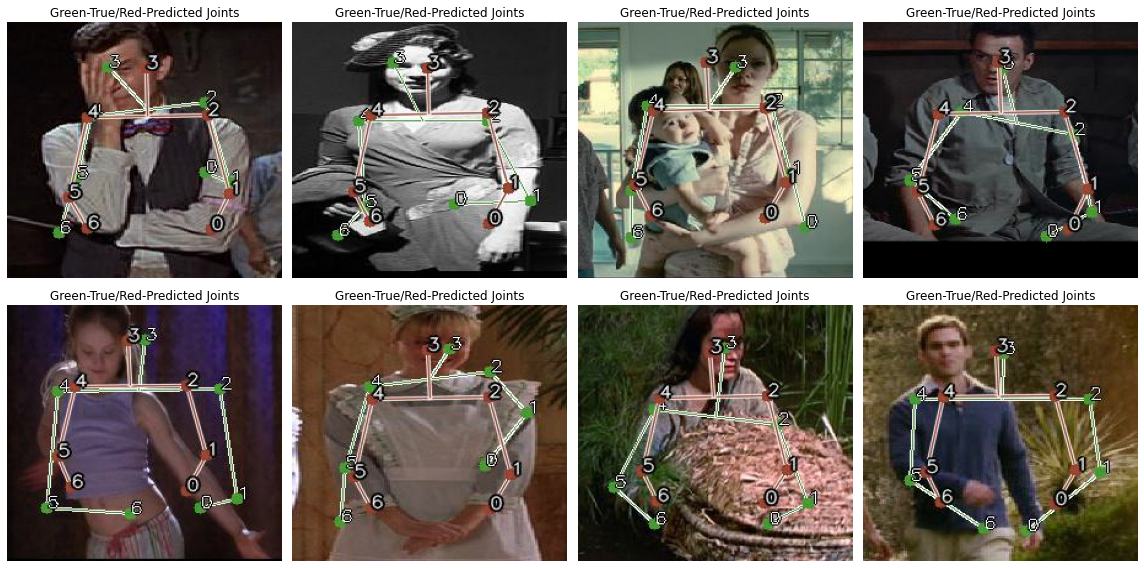

In [ ]:
import glob
image_list = glob.glob('/content/test_plot/*.jpg')[16:25]

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = cv2.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Green-True/Red-Predicted Joints')

plt.tight_layout()
plt.show()


[163.58472  181.18277  180.31543  149.8592   162.57689   81.84162
 111.90777   39.28338   65.51772   83.66767   50.492104 152.1931
  64.14953  179.5679  ]


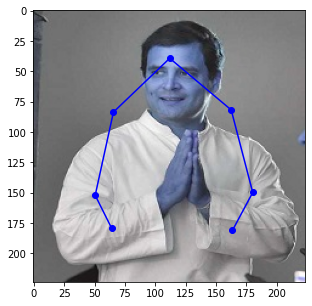

In [ ]:
def result(image):
    cords = model3.predict(image.reshape(-1,224,224,3))[0]
    print(cords)
    x=[]; y=[]
    for i in range(0,len(cords), 2):
        x.append(cords[i]); y.append(cords[i+1])

    plt.figure(figsize= (5,5))
    plt.plot(x,y,'bo-') 
    plt.imshow(image);
    #plt.grid(False);plt.axis(False)

image= cv2.imread('Action_Dataset/namaste2.jpg')
image = cv2.resize(image, (224, 224))
result(image)

# Action Recognition

In [ ]:
!unzip Action_Dataset.zip

Archive:  Action_Dataset.zip
   creating: Action_Dataset/
  inflating: Action_Dataset/action_joints.csv  
  inflating: Action_Dataset/hello1.jpg  
  inflating: Action_Dataset/hello10.jpg  
  inflating: Action_Dataset/hello2.jpg  
  inflating: Action_Dataset/hello3.jpg  
  inflating: Action_Dataset/hello4.jpg  
  inflating: Action_Dataset/hello5.jpg  
  inflating: Action_Dataset/hello6.jpg  
  inflating: Action_Dataset/hello7.jpg  
  inflating: Action_Dataset/hello8.jpg  
  inflating: Action_Dataset/hello9.jpg  
  inflating: Action_Dataset/hello_test.jpg  
  inflating: Action_Dataset/hello_trans.jpg  
  inflating: Action_Dataset/namaste1.jpg  
  inflating: Action_Dataset/namaste10.jpg  
  inflating: Action_Dataset/namaste2.jpg  
  inflating: Action_Dataset/namaste3.jpg  
  inflating: Action_Dataset/namaste4.jpg  
  inflating: Action_Dataset/namaste5.jpg  
  inflating: Action_Dataset/namaste6.jpg  
  inflating: Action_Dataset/namaste7.jpg  
  inflating: Action_Dataset/namaste8.jpg  
  in

In [ ]:
action_dataset = pd.read_csv("Action_Dataset/action_joints.csv")

In [ ]:
action_dataset

,url,j1x,j1y,j2x,j2y,j3x,j3y,j4x,j4y,j5x,j5y,j6x,j6y,j7x,j7y,label
0,hello1.jpg,152,205,165,152,157,96,123,64,106,90,81,74,48,28,Hello
1,hello2.jpg,142,184,144,133,134,93,105,56,86,84,60,65,45,19,Hello
2,hello3.jpg,155,202,151,149,141,109,101,71,60,105,47,73,53,40,Hello
3,hello4.jpg,167,216,159,161,165,111,147,66,87,88,41,102,65,49,Hello
4,hello5.jpg,140,194,137,144,131,100,105,70,77,92,60,75,60,37,Hello
5,hello6.jpg,189,218,174,169,157,121,120,84,98,117,67,94,43,46,Hello
6,hello7.jpg,184,188,168,137,153,96,120,67,84,92,69,70,76,25,Hello
7,hello8.jpg,179,161,171,118,162,68,131,36,114,64,85,49,48,27,Hello
8,hello9.jpg,154,180,160,152,143,101,112,62,76,97,55,79,82,36,Hello
9,hello10.jpg,174,193,172,140,158,95,135,65,95,95,72,70,61,30,Hello


In [ ]:
joints_cooridnates = action_dataset.iloc[:,14:0:-1]

In [ ]:
joints_cooridnates

,j7y,j7x,j6y,j6x,j5y,j5x,j4y,j4x,j3y,j3x,j2y,j2x,j1y,j1x
0,28,48,74,81,90,106,64,123,96,157,152,165,205,152
1,19,45,65,60,84,86,56,105,93,134,133,144,184,142
2,40,53,73,47,105,60,71,101,109,141,149,151,202,155
3,49,65,102,41,88,87,66,147,111,165,161,159,216,167
4,37,60,75,60,92,77,70,105,100,131,144,137,194,140
5,46,43,94,67,117,98,84,120,121,157,169,174,218,189
6,25,76,70,69,92,84,67,120,96,153,137,168,188,184
7,27,48,49,85,64,114,36,131,68,162,118,171,161,179
8,36,82,79,55,97,76,62,112,101,143,152,160,180,154
9,30,61,70,72,95,95,65,135,95,158,140,172,193,174


In [ ]:
joint_coordinates_info = action_dataset.loc[:,['url','label']]

In [ ]:
joint_coordinates_info

,url,label
0,hello1.jpg,Hello
1,hello2.jpg,Hello
2,hello3.jpg,Hello
3,hello4.jpg,Hello
4,hello5.jpg,Hello
5,hello6.jpg,Hello
6,hello7.jpg,Hello
7,hello8.jpg,Hello
8,hello9.jpg,Hello
9,hello10.jpg,Hello


In [ ]:
action_dataset_augmented = pd.concat([joint_coordinates_info,joints_cooridnates],axis=1)

In [ ]:
action_dataset_augmented

,url,label,j7y,j7x,j6y,j6x,j5y,j5x,j4y,j4x,j3y,j3x,j2y,j2x,j1y,j1x
0,hello1.jpg,Hello,28,48,74,81,90,106,64,123,96,157,152,165,205,152
1,hello2.jpg,Hello,19,45,65,60,84,86,56,105,93,134,133,144,184,142
2,hello3.jpg,Hello,40,53,73,47,105,60,71,101,109,141,149,151,202,155
3,hello4.jpg,Hello,49,65,102,41,88,87,66,147,111,165,161,159,216,167
4,hello5.jpg,Hello,37,60,75,60,92,77,70,105,100,131,144,137,194,140
5,hello6.jpg,Hello,46,43,94,67,117,98,84,120,121,157,169,174,218,189
6,hello7.jpg,Hello,25,76,70,69,92,84,67,120,96,153,137,168,188,184
7,hello8.jpg,Hello,27,48,49,85,64,114,36,131,68,162,118,171,161,179
8,hello9.jpg,Hello,36,82,79,55,97,76,62,112,101,143,152,160,180,154
9,hello10.jpg,Hello,30,61,70,72,95,95,65,135,95,158,140,172,193,174


In [ ]:
df = action_dataset_augmented[['url','j1y','j1x','j2y','j2x','j3y','j3x','j4y','j4x','j5y','j5x','j6y','j6x','j7y','j7x','label']]

In [ ]:
df

,url,j1y,j1x,j2y,j2x,j3y,j3x,j4y,j4x,j5y,j5x,j6y,j6x,j7y,j7x,label
0,hello1.jpg,205,152,152,165,96,157,64,123,90,106,74,81,28,48,Hello
1,hello2.jpg,184,142,133,144,93,134,56,105,84,86,65,60,19,45,Hello
2,hello3.jpg,202,155,149,151,109,141,71,101,105,60,73,47,40,53,Hello
3,hello4.jpg,216,167,161,159,111,165,66,147,88,87,102,41,49,65,Hello
4,hello5.jpg,194,140,144,137,100,131,70,105,92,77,75,60,37,60,Hello
5,hello6.jpg,218,189,169,174,121,157,84,120,117,98,94,67,46,43,Hello
6,hello7.jpg,188,184,137,168,96,153,67,120,92,84,70,69,25,76,Hello
7,hello8.jpg,161,179,118,171,68,162,36,131,64,114,49,85,27,48,Hello
8,hello9.jpg,180,154,152,160,101,143,62,112,97,76,79,55,36,82,Hello
9,hello10.jpg,193,174,140,172,95,158,65,135,95,95,70,72,30,61,Hello


In [ ]:
action_dataset.columns

Index(['url', 'j1x', 'j1y', 'j2x', 'j2y', 'j3x', 'j3y', 'j4x', 'j4y', 'j5x',
       'j5y', 'j6x', 'j6y', 'j7x', 'j7y', 'label'],
      dtype='object')

In [ ]:
df = df.rename({"j7x":"j1x","j7y":"j1y","j6x":"j2x","j6y":"j2y","j5x":"j3x","j5y":"j3y","j3x":"j5x","j3y":"j5y","j2x":"j6x","j2y":"j6y","j1x":"j7x","j1y":"j7y"},axis=1)

In [ ]:
df

,url,j7y,j7x,j6y,j6x,j5y,j5x,j4y,j4x,j3y,j3x,j2y,j2x,j1y,j1x,label
0,hello1.jpg,205,152,152,165,96,157,64,123,90,106,74,81,28,48,Hello
1,hello2.jpg,184,142,133,144,93,134,56,105,84,86,65,60,19,45,Hello
2,hello3.jpg,202,155,149,151,109,141,71,101,105,60,73,47,40,53,Hello
3,hello4.jpg,216,167,161,159,111,165,66,147,88,87,102,41,49,65,Hello
4,hello5.jpg,194,140,144,137,100,131,70,105,92,77,75,60,37,60,Hello
5,hello6.jpg,218,189,169,174,121,157,84,120,117,98,94,67,46,43,Hello
6,hello7.jpg,188,184,137,168,96,153,67,120,92,84,70,69,25,76,Hello
7,hello8.jpg,161,179,118,171,68,162,36,131,64,114,49,85,27,48,Hello
8,hello9.jpg,180,154,152,160,101,143,62,112,97,76,79,55,36,82,Hello
9,hello10.jpg,193,174,140,172,95,158,65,135,95,95,70,72,30,61,Hello


In [ ]:
action_dataset_final = pd.concat([action_dataset,df],ignore_index=True)

In [ ]:
action_dataset_final

,url,j1x,j1y,j2x,j2y,j3x,j3y,j4x,j4y,j5x,j5y,j6x,j6y,j7x,j7y,label
0,hello1.jpg,152,205,165,152,157,96,123,64,106,90,81,74,48,28,Hello
1,hello2.jpg,142,184,144,133,134,93,105,56,86,84,60,65,45,19,Hello
2,hello3.jpg,155,202,151,149,141,109,101,71,60,105,47,73,53,40,Hello
3,hello4.jpg,167,216,159,161,165,111,147,66,87,88,41,102,65,49,Hello
4,hello5.jpg,140,194,137,144,131,100,105,70,77,92,60,75,60,37,Hello
5,hello6.jpg,189,218,174,169,157,121,120,84,98,117,67,94,43,46,Hello
6,hello7.jpg,184,188,168,137,153,96,120,67,84,92,69,70,76,25,Hello
7,hello8.jpg,179,161,171,118,162,68,131,36,114,64,85,49,48,27,Hello
8,hello9.jpg,154,180,160,152,143,101,112,62,76,97,55,79,82,36,Hello
9,hello10.jpg,174,193,172,140,158,95,135,65,95,95,72,70,61,30,Hello


In [ ]:
action_dataset_final = action_dataset_final.replace({'Namaste':0,'Hello':1})

In [ ]:
action_dataset_final

,url,j1x,j1y,j2x,j2y,j3x,j3y,j4x,j4y,j5x,j5y,j6x,j6y,j7x,j7y,label
0,hello1.jpg,152,205,165,152,157,96,123,64,106,90,81,74,48,28,1
1,hello2.jpg,142,184,144,133,134,93,105,56,86,84,60,65,45,19,1
2,hello3.jpg,155,202,151,149,141,109,101,71,60,105,47,73,53,40,1
3,hello4.jpg,167,216,159,161,165,111,147,66,87,88,41,102,65,49,1
4,hello5.jpg,140,194,137,144,131,100,105,70,77,92,60,75,60,37,1
5,hello6.jpg,189,218,174,169,157,121,120,84,98,117,67,94,43,46,1
6,hello7.jpg,184,188,168,137,153,96,120,67,84,92,69,70,76,25,1
7,hello8.jpg,179,161,171,118,162,68,131,36,114,64,85,49,48,27,1
8,hello9.jpg,154,180,160,152,143,101,112,62,76,97,55,79,82,36,1
9,hello10.jpg,174,193,172,140,158,95,135,65,95,95,72,70,61,30,1


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = action_dataset_final.iloc[:,-1].values.reshape(-1,1)   
enc= OneHotEncoder()
y= enc.fit_transform(y).toarray()

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split
trainX, testx, trainY, testy = train_test_split(action_dataset_final.iloc[:,1:15],y,test_size=0.2)

In [ ]:
print(trainX.shape)
print(trainY.shape)

(35, 14)
(35, 2)


In [ ]:
# trainX = trainX.astype('float32')
# trainY = trainY.astype('float32')
# testx = testx.astype('float32')
# testy = testy.astype('float32')

In [ ]:
print(type(trainX))
print(type(testx))
print(type(trainY))
print(type(testy))
print(trainX.dtypes)
print(trainY.dtypes)
print(testx.dtypes)
print(testy.dtypes)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
j1x    float32
j1y    float32
j2x    float32
j2y    float32
j3x    float32
j3y    float32
j4x    float32
j4y    float32
j5x    float32
j5y    float32
j6x    float32
j6y    float32
j7x    float32
j7y    float32
dtype: object
float32
j1x    float32
j1y    float32
j2x    float32
j2y    float32
j3x    float32
j3y    float32
j4x    float32
j4y    float32
j5x    float32
j5y    float32
j6x    float32
j6y    float32
j7x    float32
j7y    float32
dtype: object
float32


In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(1024*2, input_shape=[14], activation= 'relu', activity_regularizer='l2', kernel_initializer='TruncatedNormal')) 
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(14, activation= 'relu', activity_regularizer='l2'))
model.add(BatchNormalization()) 

model.add(Dense(2, activation= 'sigmoid'))

In [ ]:
model.compile(optimizer="Adam",metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
model.fit(trainX, trainY, validation_data=(testx,testy),epochs=50)

Epoch 1/50
2/2 [==============================] - 1s 288ms/step - loss: 3951.6702 - accuracy: 0.6083 - val_loss: 2849.5532 - val_accuracy: 0.7778
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 3040.0215 - accuracy: 0.8821 - val_loss: 2169.0898 - val_accuracy: 0.7778
Epoch 3/50
2/2 [==============================] - 0s 46ms/step - loss: 2321.9615 - accuracy: 0.9411 - val_loss: 1626.6433 - val_accuracy: 0.7778
Epoch 4/50
2/2 [==============================] - 0s 44ms/step - loss: 1762.2679 - accuracy: 0.9220 - val_loss: 1210.2262 - val_accuracy: 0.7778
Epoch 5/50
2/2 [==============================] - 0s 41ms/step - loss: 1322.6513 - accuracy: 0.9220 - val_loss: 896.4366 - val_accuracy: 0.7778
Epoch 6/50
2/2 [==============================] - 0s 44ms/step - loss: 989.1270 - accuracy: 0.9411 - val_loss: 662.1140 - val_accuracy: 0.7778
Epoch 7/50
2/2 [==============================] - 0s 41ms/step - loss: 733.7967 - accuracy: 0.9220 - val_loss: 487.9536 - val_accura

In [ ]:
model.save_weights("action_recognition.h5")

In [ ]:
action_recognition_json = model.to_json()
with open("action_recognition_json.json","w") as f:
  f.write(action_recognition_json)

In [ ]:
model.save("action_recognition_full.h5")

In [ ]:
json_file = open("pose_estimation.json","r")
json_file_loaded = json_file.read()
json_file.close()
model_pose_estimation_json = tf.keras.models.model_from_json(json_file_loaded)
model_pose_estimation = model_pose_estimation_json.load_weights("pose_estimation.h5")

In [ ]:
img = tfkpreimage.load_img("Action_Dataset/namaste_test.jpg",target_size=(224,224))
imgarray = tfkpreimage.img_to_array(img)
imgarray = np.expand_dims(imgarray,axis=0)
imgarray /= 255.0

In [ ]:
imgarray.shape

(1, 224, 224, 3)

In [ ]:
coords = model_pose_estimation_json.predict(imgarray)

In [ ]:
coords = coords[0]

In [ ]:
x=[]; y=[]
for i in range(0,14, 2):
    x.append(coords[i]); y.append(coords[i+1])

cords= coords.reshape((-1,14)) 

#dist_data = joint_coordinates(cords[0])   #Use these commands if using euclidean dist model
#dist_data = dist_data.reshape((-1,6))
#action = np.argmax(action_model.predict(dist_data), axis=-1)

action = model.predict_classes(cords)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(action)

[0]


In [ ]:
print(coords.astype(np.uint8).tolist())

[202, 211, 221, 175, 198, 94, 131, 45, 68, 96, 48, 177, 66, 208]


In [ ]:
#testimg = tfkpreimage.load_img("Action_Dataset/namaste_test.jpg",target_size=(150,150))
testimgarray = tfkpreimage.img_to_array(img)
pred = coords.astype(np.uint8).tolist()
pred = list(zip(coords[0::2], coords[1::2]))

In [ ]:
im = plot_joints(testimgarray.astype(np.uint8),pred,original=False,text_scale=0.5)

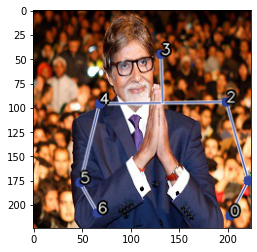

In [ ]:
plt.imshow(im)